In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
import time
from huggingface_hub import login
from datasets import load_dataset, load_from_disk
import numpy as np
from tqdm import tqdm
import random
import os
!pip install human-eval
import human_eval
# Login with token from environment variable or set your token here
# login(token=os.getenv("HF_TOKEN", "YOUR_HUGGINGFACE_TOKEN_HERE"))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.7 MB/s eta 0:00:00


In [2]:
# checkpoint = "facebook/layerskip-llama3-8B"
checkpoint = "facebook/layerskip-llama3.2-1B"

# Option 1: Load just the config (fastest, no download of weights)
config = AutoConfig.from_pretrained(checkpoint)
num_layers = config.num_hidden_layers
print(f"Number of layers: {num_layers}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

Number of layers: 16


In [3]:
from copy import deepcopy

# checkpoint = "facebook/layerskip-llama3-8B"
checkpoint = "facebook/layerskip-llama3.2-1B"
early_exit = 4
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "typing import List\ndef bucket_sort(A: List):"

model = AutoModelForCausalLM.from_pretrained(
    checkpoint,
    device_map="auto",
    use_safetensors=True,
    torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# generation_config = model.generation_config
start_time = time.time()
weights_memo = {id(w): w for w in model.parameters()}
assistant_model = deepcopy(model, memo=weights_memo) # Clone main model with shared weights
assistant_model.model.layers = assistant_model.model.layers[:early_exit] # Apply early exit
del assistant_model.model.layers[early_exit:]
weights_memo_time = time.time() - start_time
print(f"weight memo time: {weights_memo_time:.2f}s")

inputs = tokenizer(prompt, return_tensors="pt").to(device)

# outputs = assistant_model.generate(**inputs, max_new_tokens=512)

torch.cuda.synchronize()
start_time = time.time()

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        temperature=0.0,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

torch.cuda.synchronize()
batch_time = time.time() - start_time

print(f"Batch time: {batch_time:.2f}s")
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


weight memo time: 0.01s
Batch time: 5.98s
typing import List
def bucket_sort(A: List): 
    if len(A) == 0:
        return A
    else:
        bucket = []
        for i in range(len(A)):
            bucket.append(A[i])
        bucket.sort()
        return bucket
#    return sorted(A)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x)
#    return sorted(A, key=lambda x: x



Loading model: facebook/layerskip-llama3.2-1B
Total layers in model: 16
Testing early exit points: [4, 6, 8, 10, 12, 14, 16]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/16
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 135.75
  ✓ Generation time: 3.26s
  ✓ Tokens/sec: 157.11

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/16
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 83.62
  ✓ Generation time: 4.08s
  ✓ Tokens/sec: 125.52

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/16
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 69.60
  ✓ Generation time: 5.16s
  ✓ Tokens/sec: 99.28

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/16
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 50.32
  ✓ Generation time: 6.34s
  ✓ Tokens/sec: 80.76

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/16
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 37.84
  ✓ Generation time: 7.51s
  ✓ Tokens/sec: 68.19

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/16
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 29.65
  ✓ Generation time: 8.62s
  ✓ Tokens/sec: 59.42

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/16
--------------------------------------------------------------------------------
  Using full model (16 layers)
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


  ✓ Perplexity (WikiText): 27.00
  ✓ Generation time: 9.60s
  ✓ Tokens/sec: 53.31

Loading model: meta-llama/Llama-3.2-1B


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Total layers in model: 16
Testing early exit points: [4, 6, 8, 10, 12, 14, 16]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/16
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 803884.31
  ✓ Generation time: 3.05s
  ✓ Tokens/sec: 168.01

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/16
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 246465.21
  ✓ Generation time: 4.22s
  ✓ Tokens/sec: 121.43

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/16
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 235984.89
  ✓ Generation time: 5.22s
  ✓ Tokens/sec: 98.10

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/16
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 77093.77
  ✓ Generation time: 6.25s
  ✓ Tokens/sec: 81.96

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/16
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 12536.84
  ✓ Generation time: 7.44s
  ✓ Tokens/sec: 68.78

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/16
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 738.65
  ✓ Generation time: 8.64s
  ✓ Tokens/sec: 59.28

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/16
--------------------------------------------------------------------------------
  Using full model (16 layers)
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 25.06
  ✓ Generation time: 2.52s
  ✓ Tokens/sec: 53.18

Loading model: facebook/layerskip-llama3-8B


config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Total layers in model: 32
Testing early exit points: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/32
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 164.82
  ✓ Generation time: 3.16s
  ✓ Tokens/sec: 161.82

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/32
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 102.67
  ✓ Generation time: 4.28s
  ✓ Tokens/sec: 119.63

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/32
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 65.87
  ✓ Generation time: 5.40s
  ✓ Tokens/sec: 94.82

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/32
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 57.74
  ✓ Generation time: 6.52s
  ✓ Tokens/sec: 78.55

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/32
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 50.64
  ✓ Generation time: 7.74s
  ✓ Tokens/sec: 66.17

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/32
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 44.78
  ✓ Generation time: 1.67s
  ✓ Tokens/sec: 59.36

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/32
--------------------------------------------------------------------------------
  Truncated to 16 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 38.43
  ✓ Generation time: 2.13s
  ✓ Tokens/sec: 53.00

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 18/32
--------------------------------------------------------------------------------
  Truncated to 18 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 32.07
  ✓ Generation time: 10.80s
  ✓ Tokens/sec: 47.41

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 20/32
--------------------------------------------------------------------------------
  Truncated to 20 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 28.77
  ✓ Generation time: 1.68s
  ✓ Tokens/sec: 42.30

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 22/32
--------------------------------------------------------------------------------
  Truncated to 22 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 25.69
  ✓ Generation time: 2.41s
  ✓ Tokens/sec: 38.94

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 24/32
--------------------------------------------------------------------------------
  Truncated to 24 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 23.67
  ✓ Generation time: 2.69s
  ✓ Tokens/sec: 36.04

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 26/32
--------------------------------------------------------------------------------
  Truncated to 26 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 22.09
  ✓ Generation time: 2.79s
  ✓ Tokens/sec: 34.03

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 28/32
--------------------------------------------------------------------------------
  Truncated to 28 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 20.35
  ✓ Generation time: 1.38s
  ✓ Tokens/sec: 31.24

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 30/32
--------------------------------------------------------------------------------
  Truncated to 30 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 18.76
  ✓ Generation time: 3.75s
  ✓ Tokens/sec: 29.32

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 32/32
--------------------------------------------------------------------------------
  Using full model (32 layers)
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 16.87
  ✓ Generation time: 18.81s
  ✓ Tokens/sec: 27.21

Loading model: meta-llama/Llama-3.1-8B


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Total layers in model: 32
Testing early exit points: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/32
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 1129397.13
  ✓ Generation time: 3.07s
  ✓ Tokens/sec: 166.73

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/32
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 699362.01
  ✓ Generation time: 4.15s
  ✓ Tokens/sec: 123.25

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/32
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 567865.82
  ✓ Generation time: 5.28s
  ✓ Tokens/sec: 97.03

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/32
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 447806.16
  ✓ Generation time: 6.40s
  ✓ Tokens/sec: 79.97

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/32
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 464013.86
  ✓ Generation time: 7.52s
  ✓ Tokens/sec: 68.09

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/32
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 199565.73
  ✓ Generation time: 8.58s
  ✓ Tokens/sec: 59.70

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/32
--------------------------------------------------------------------------------
  Truncated to 16 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 94631.73
  ✓ Generation time: 9.70s
  ✓ Tokens/sec: 52.76

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 18/32
--------------------------------------------------------------------------------
  Truncated to 18 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 19275.04
  ✓ Generation time: 10.92s
  ✓ Tokens/sec: 46.88

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 20/32
--------------------------------------------------------------------------------
  Truncated to 20 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 8188.54
  ✓ Generation time: 12.33s
  ✓ Tokens/sec: 41.53

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 22/32
--------------------------------------------------------------------------------
  Truncated to 22 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 3714.40
  ✓ Generation time: 12.93s
  ✓ Tokens/sec: 39.61

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 24/32
--------------------------------------------------------------------------------
  Truncated to 24 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 2100.79
  ✓ Generation time: 14.24s
  ✓ Tokens/sec: 35.95

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 26/32
--------------------------------------------------------------------------------
  Truncated to 26 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 1085.93
  ✓ Generation time: 15.34s
  ✓ Tokens/sec: 33.38

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 28/32
--------------------------------------------------------------------------------
  Truncated to 28 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 415.30
  ✓ Generation time: 16.50s
  ✓ Tokens/sec: 31.02

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 30/32
--------------------------------------------------------------------------------
  Truncated to 30 layers
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 143.09
  ✓ Generation time: 17.71s
  ✓ Tokens/sec: 28.90

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 32/32
--------------------------------------------------------------------------------
  Using full model (32 layers)
  Evaluating perplexity on wikitext...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  ✓ Perplexity (WikiText): 17.10
  ✓ Generation time: 2.57s
  ✓ Tokens/sec: 27.67

FINAL RESULTS SUMMARY
                      model  early_exit_layer  perplexity_wikitext  generation_time_sec  tokens_generated  tokens_per_sec
      LayerSkip Llama3.2 1B                 4         1.357456e+02             3.258882               512      157.109081
      LayerSkip Llama3.2 1B                 6         8.362167e+01             4.078878               512      125.524718
      LayerSkip Llama3.2 1B                 8         6.960266e+01             5.157274               512       99.277263
      LayerSkip Llama3.2 1B                10         5.031899e+01             6.339782               512       80.759881
      LayerSkip Llama3.2 1B                12         3.784388e+01             7.508300               512       68.191201
      LayerSkip Llama3.2 1B                14         2.964624e+01             8.616340               512       59.421981
      LayerSkip Llama3.2 1B              

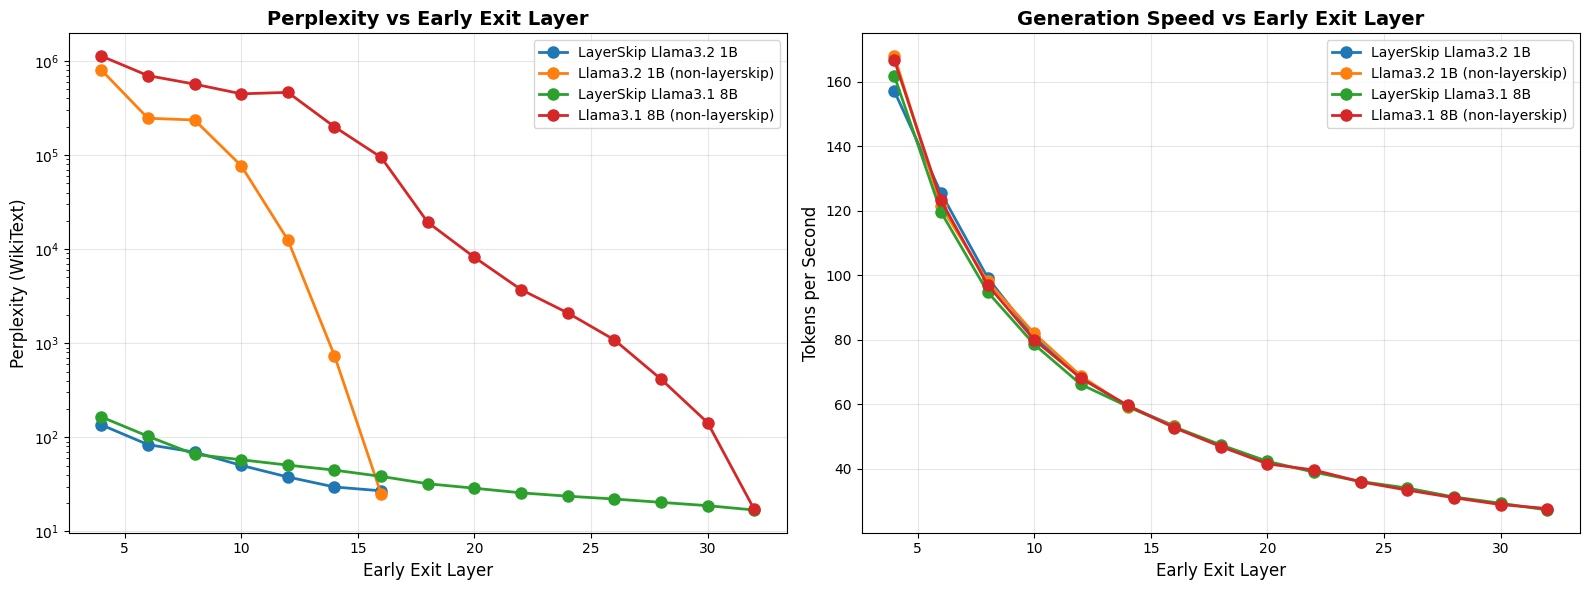

Tradeoff plot saved as 'layerskip_tradeoff.png'


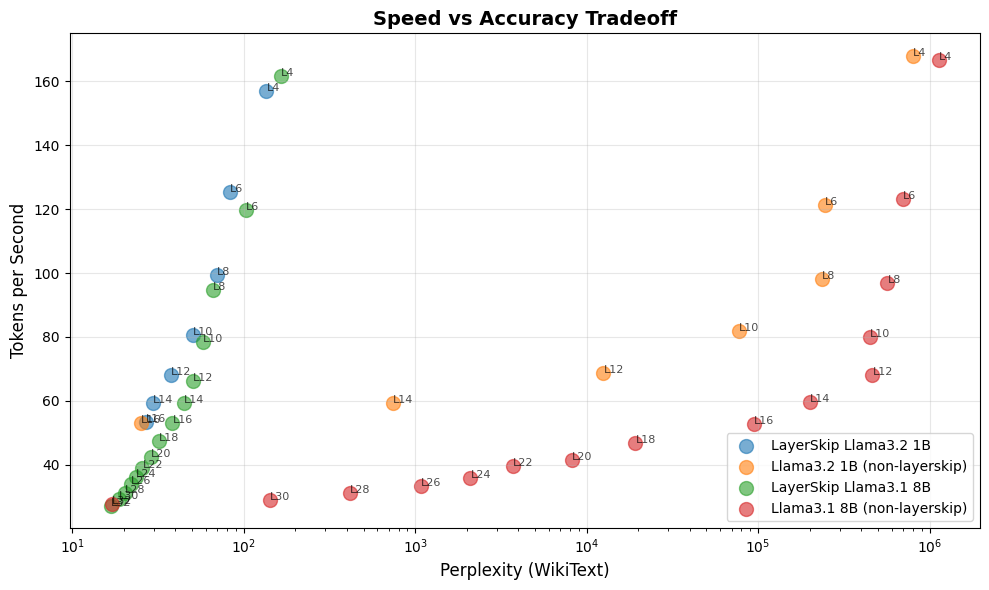


EVALUATION COMPLETE

Summary Statistics:

LayerSkip Llama3.2 1B:
  Best perplexity: 27.00 at layer 16
  Best speed: 157.11 tokens/sec at layer 4
  Speedup at layer 8: 1.86x

Llama3.2 1B (non-layerskip):
  Best perplexity: 25.06 at layer 16
  Best speed: 168.01 tokens/sec at layer 4
  Speedup at layer 8: 1.84x

LayerSkip Llama3.1 8B:
  Best perplexity: 16.87 at layer 32
  Best speed: 161.82 tokens/sec at layer 4
  Speedup at layer 8: 3.48x

Llama3.1 8B (non-layerskip):
  Best perplexity: 17.10 at layer 32
  Best speed: 166.73 tokens/sec at layer 4
  Speedup at layer 8: 3.51x


In [4]:
import torch
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import pandas as pd

def evaluate_perplexity(model, tokenizer, device, dataset_name="wikitext", split="test", max_samples=100):
    """Calculate perplexity on a dataset"""
    print(f"  Evaluating perplexity on {dataset_name}...")

    if dataset_name == "wikitext":
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)
    else:
        dataset = load_dataset(dataset_name, split=split)

    dataset = dataset.select(range(min(max_samples, len(dataset))))

    total_loss = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="  Computing perplexity", leave=False):
            text = item['text'] if 'text' in item else str(item)

            if len(text.strip()) == 0:
                continue

            encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            input_ids = encodings.input_ids.to(device)

            if input_ids.shape[1] < 2:
                continue

            outputs = model(input_ids, labels=input_ids)
            num_tokens = input_ids.shape[1]
            total_loss += outputs.loss.item() * num_tokens
            total_tokens += num_tokens

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = np.exp(avg_loss)
    return perplexity


def evaluate_generation_speed(model, tokenizer, device, prompt, max_new_tokens=512):
    """Measure generation speed"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    batch_time = time.time() - start_time

    # Calculate tokens per second
    num_tokens_generated = outputs.shape[1] - inputs.input_ids.shape[1]
    tokens_per_sec = num_tokens_generated / batch_time if batch_time > 0 else 0

    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    return {
        'batch_time': batch_time,
        'tokens_generated': num_tokens_generated,
        'tokens_per_sec': tokens_per_sec,
        'generated_text': generated_text
    }


def evaluate_model_at_different_exits(checkpoint, model_name, device, prompt, max_samples=100):
    """Evaluate a single model at different early exit points"""

    print(f"\n{'='*80}")
    print(f"Loading model: {checkpoint}")
    print(f"{'='*80}")

    base_model = AutoModelForCausalLM.from_pretrained(
        checkpoint,
        device_map="auto",
        use_safetensors=True,
        torch_dtype=torch.bfloat16
    )
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # Get total number of layers
    num_layers = len(base_model.model.layers)
    print(f"Total layers in model: {num_layers}")

    # Define early exit points to test
    # Adjust based on model size
    early_exit_points = list(range(4, num_layers, 2)) + [num_layers]

    print(f"Testing early exit points: {early_exit_points}")

    # Store results
    results = []

    for early_exit in early_exit_points:
        print(f"\n{'-'*80}")
        print(f"Evaluating Early Exit at Layer {early_exit}/{num_layers}")
        print(f"{'-'*80}")

        # Create model with early exit
        weights_memo = {id(w): w for w in base_model.parameters()}
        eval_model = deepcopy(base_model, memo=weights_memo)

        if early_exit < num_layers:
            eval_model.model.layers = eval_model.model.layers[:early_exit]
            del eval_model.model.layers[early_exit:]
            print(f"  Truncated to {len(eval_model.model.layers)} layers")
        else:
            print(f"  Using full model ({num_layers} layers)")

        # Evaluate perplexity on WikiText
        ppl_wikitext = evaluate_perplexity(
            eval_model,
            tokenizer,
            device,
            dataset_name="wikitext",
            max_samples=max_samples
        )

        # Evaluate generation speed
        gen_results = evaluate_generation_speed(
            eval_model,
            tokenizer,
            device,
            prompt,
            max_new_tokens=512
        )

        # Store results
        result = {
            'model': model_name,
            'early_exit_layer': early_exit,
            'perplexity_wikitext': ppl_wikitext,
            'generation_time_sec': gen_results['batch_time'],
            'tokens_generated': gen_results['tokens_generated'],
            'tokens_per_sec': gen_results['tokens_per_sec'],
        }
        results.append(result)

        print(f"  ✓ Perplexity (WikiText): {ppl_wikitext:.2f}")
        print(f"  ✓ Generation time: {gen_results['batch_time']:.2f}s")
        print(f"  ✓ Tokens/sec: {gen_results['tokens_per_sec']:.2f}")

        # Clean up
        del eval_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Clean up base model
    del base_model
    del tokenizer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results


# Main evaluation code
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "typing import List\ndef bucket_sort(A: List):"

# Models to evaluate
models_to_evaluate = [
    {
        'checkpoint': "facebook/layerskip-llama3.2-1B",
        'name': "LayerSkip Llama3.2 1B"
    },
    {
        'checkpoint': "meta-llama/Llama-3.2-1B",
        'name': "Llama3.2 1B (non-layerskip)"
    },
    {
        'checkpoint': "facebook/layerskip-llama3-8B",
        'name': "LayerSkip Llama3.1 8B"
    },
    {
        'checkpoint': "meta-llama/Llama-3.1-8B",
        'name': "Llama3.1 8B (non-layerskip)"
    }

]

# Collect all results
all_results = []

for model_config in models_to_evaluate:
    results = evaluate_model_at_different_exits(
        checkpoint=model_config['checkpoint'],
        model_name=model_config['name'],
        device=device,
        prompt=prompt,
        max_samples=100  # Increase for more accurate results
    )
    all_results.extend(results)

# Create DataFrame with all results
df_results = pd.DataFrame(all_results)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))

# Save to CSV
df_results.to_csv('layerskip_comparison_results.csv', index=False)
print("\nResults saved to 'layerskip_comparison_results.csv'")

# Plot results
try:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Perplexity vs Early Exit Layer
    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        ax1.plot(
            model_data['early_exit_layer'],
            model_data['perplexity_wikitext'],
            'o-',
            linewidth=2,
            markersize=8,
            label=model_name
        )

    ax1.set_xlabel('Early Exit Layer', fontsize=12)
    ax1.set_ylabel('Perplexity (WikiText)', fontsize=12)
    ax1.set_title('Perplexity vs Early Exit Layer', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Plot 2: Tokens per Second vs Early Exit Layer
    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        ax2.plot(
            model_data['early_exit_layer'],
            model_data['tokens_per_sec'],
            'o-',
            linewidth=2,
            markersize=8,
            label=model_name
        )

    ax2.set_xlabel('Early Exit Layer', fontsize=12)
    ax2.set_ylabel('Tokens per Second', fontsize=12)
    ax2.set_title('Generation Speed vs Early Exit Layer', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('layerskip_comparison.png', dpi=150, bbox_inches='tight')
    print("Plot saved as 'layerskip_comparison.png'")
    plt.show()

    # Additional plot: Speed vs Perplexity tradeoff
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        scatter = ax.scatter(
            model_data['perplexity_wikitext'],
            model_data['tokens_per_sec'],
            s=100,
            alpha=0.6,
            label=model_name
        )

        # Add layer numbers as annotations
        for idx, row in model_data.iterrows():
            ax.annotate(
                f"L{row['early_exit_layer']}",
                (row['perplexity_wikitext'], row['tokens_per_sec']),
                fontsize=8,
                alpha=0.7
            )

    ax.set_xlabel('Perplexity (WikiText)', fontsize=12)
    ax.set_ylabel('Tokens per Second', fontsize=12)
    ax.set_title('Speed vs Accuracy Tradeoff', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('layerskip_tradeoff.png', dpi=150, bbox_inches='tight')
    print("Tradeoff plot saved as 'layerskip_tradeoff.png'")
    plt.show()

except ImportError:
    print("\nMatplotlib not available - skipping plots")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)

# Print summary statistics
print("\nSummary Statistics:")
for model_name in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model_name]
    print(f"\n{model_name}:")
    print(f"  Best perplexity: {model_data['perplexity_wikitext'].min():.2f} at layer {model_data.loc[model_data['perplexity_wikitext'].idxmin(), 'early_exit_layer']:.0f}")
    print(f"  Best speed: {model_data['tokens_per_sec'].max():.2f} tokens/sec at layer {model_data.loc[model_data['tokens_per_sec'].idxmax(), 'early_exit_layer']:.0f}")
    print(f"  Speedup at layer 8: {model_data[model_data['early_exit_layer']==8]['tokens_per_sec'].values[0] / model_data[model_data['early_exit_layer']==model_data['early_exit_layer'].max()]['tokens_per_sec'].values[0]:.2f}x")

Plot saved as 'layerskip_comparison.png'


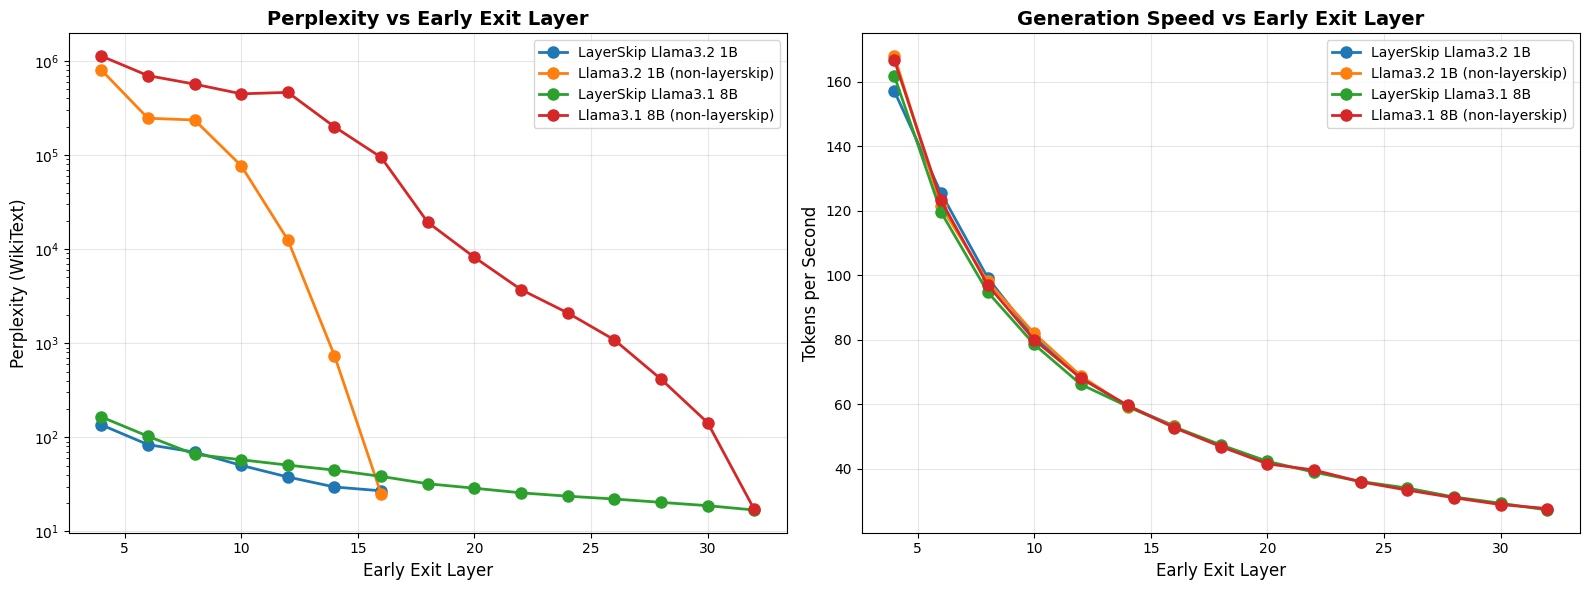

Tradeoff plot saved as 'layerskip_tradeoff.png'


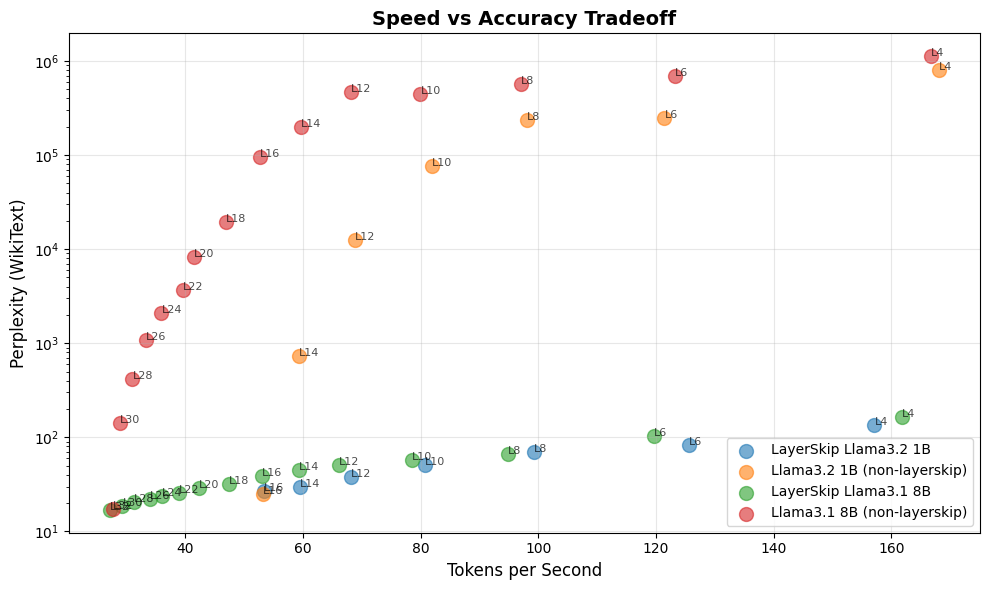


EVALUATION COMPLETE


In [5]:
try:
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Perplexity vs Early Exit Layer
    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        ax1.plot(
            model_data['early_exit_layer'],
            model_data['perplexity_wikitext'],
            'o-',
            linewidth=2,
            markersize=8,
            label=model_name
        )

    ax1.set_xlabel('Early Exit Layer', fontsize=12)
    ax1.set_ylabel('Perplexity (WikiText)', fontsize=12)
    ax1.set_title('Perplexity vs Early Exit Layer', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Plot 2: Tokens per Second vs Early Exit Layer
    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        ax2.plot(
            model_data['early_exit_layer'],
            model_data['tokens_per_sec'],
            'o-',
            linewidth=2,
            markersize=8,
            label=model_name
        )

    ax2.set_xlabel('Early Exit Layer', fontsize=12)
    ax2.set_ylabel('Tokens per Second', fontsize=12)
    ax2.set_title('Generation Speed vs Early Exit Layer', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('layerskip_comparison.png', dpi=150, bbox_inches='tight')
    print("Plot saved as 'layerskip_comparison.png'")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        scatter = ax.scatter(
            model_data['tokens_per_sec'],  # Flipped: now on x-axis
            model_data['perplexity_wikitext'],  # Flipped: now on y-axis
            s=100,
            alpha=0.6,
            label=model_name
        )

        # Add layer numbers as annotations
        for idx, row in model_data.iterrows():
            ax.annotate(
                f"L{row['early_exit_layer']}",
                (row['tokens_per_sec'], row['perplexity_wikitext']),  # Flipped coordinates
                fontsize=8,
                alpha=0.7
            )

    ax.set_xlabel('Tokens per Second', fontsize=12)  # Flipped label
    ax.set_ylabel('Perplexity (WikiText)', fontsize=12)  # Flipped label
    ax.set_title('Speed vs Accuracy Tradeoff', fontsize=14, fontweight='bold')
    ax.set_yscale('log')  # Flipped: log scale now on y-axis
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('layerskip_tradeoff.png', dpi=150, bbox_inches='tight')
    print("Tradeoff plot saved as 'layerskip_tradeoff.png'")
    plt.show()

except ImportError:
    print("\nMatplotlib not available - skipping plots")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)


Loading model: facebook/layerskip-llama3.2-1B
Total layers in model: 16
Testing early exit points: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/16
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


README.md: 0.00B [00:00, ?B/s]

copa/train-00000-of-00001.parquet:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

copa/validation-00000-of-00001.parquet:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

copa/test-00000-of-00001.parquet:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 135.75
  ✓ HellaSwag: 33.00%
  ✓ COPA: 57.00%
  ✓ ARC-Easy: 33.00%
  ✓ Generation time: 3.05s
  ✓ Tokens/sec: 167.63

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 5/16
--------------------------------------------------------------------------------
  Truncated to 5 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 102.54
  ✓ HellaSwag: 33.00%
  ✓ COPA: 59.00%
  ✓ ARC-Easy: 27.00%
  ✓ Generation time: 3.57s
  ✓ Tokens/sec: 143.35

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/16
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 83.62
  ✓ HellaSwag: 36.00%
  ✓ COPA: 63.00%
  ✓ ARC-Easy: 30.00%
  ✓ Generation time: 4.02s
  ✓ Tokens/sec: 127.42

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 7/16
--------------------------------------------------------------------------------
  Truncated to 7 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 77.41
  ✓ HellaSwag: 37.00%
  ✓ COPA: 64.00%
  ✓ ARC-Easy: 32.00%
  ✓ Generation time: 4.73s
  ✓ Tokens/sec: 108.16

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/16
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 69.60
  ✓ HellaSwag: 38.00%
  ✓ COPA: 64.00%
  ✓ ARC-Easy: 38.00%
  ✓ Generation time: 5.23s
  ✓ Tokens/sec: 97.84

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 9/16
--------------------------------------------------------------------------------
  Truncated to 9 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 63.11
  ✓ HellaSwag: 41.00%
  ✓ COPA: 68.00%
  ✓ ARC-Easy: 41.00%
  ✓ Generation time: 5.96s
  ✓ Tokens/sec: 85.97

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/16
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 50.32
  ✓ HellaSwag: 41.00%
  ✓ COPA: 70.00%
  ✓ ARC-Easy: 54.00%
  ✓ Generation time: 6.59s
  ✓ Tokens/sec: 77.65

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 11/16
--------------------------------------------------------------------------------
  Truncated to 11 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 42.87
  ✓ HellaSwag: 44.00%
  ✓ COPA: 74.00%
  ✓ ARC-Easy: 54.00%
  ✓ Generation time: 6.84s
  ✓ Tokens/sec: 74.89

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/16
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 37.84
  ✓ HellaSwag: 45.00%
  ✓ COPA: 79.00%
  ✓ ARC-Easy: 57.00%
  ✓ Generation time: 7.51s
  ✓ Tokens/sec: 68.19

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 13/16
--------------------------------------------------------------------------------
  Truncated to 13 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 33.54
  ✓ HellaSwag: 44.00%
  ✓ COPA: 78.00%
  ✓ ARC-Easy: 53.00%
  ✓ Generation time: 8.18s
  ✓ Tokens/sec: 62.63

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/16
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 29.65
  ✓ HellaSwag: 45.00%
  ✓ COPA: 77.00%
  ✓ ARC-Easy: 60.00%
  ✓ Generation time: 8.60s
  ✓ Tokens/sec: 59.53

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 15/16
--------------------------------------------------------------------------------
  Truncated to 15 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 27.58
  ✓ HellaSwag: 46.00%
  ✓ COPA: 78.00%
  ✓ ARC-Easy: 64.00%
  ✓ Generation time: 9.11s
  ✓ Tokens/sec: 56.18

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/16
--------------------------------------------------------------------------------
  Using full model (16 layers)
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 27.00
  ✓ HellaSwag: 46.00%
  ✓ COPA: 82.00%
  ✓ ARC-Easy: 66.00%
  ✓ Generation time: 9.74s
  ✓ Tokens/sec: 52.55

Loading model: meta-llama/Llama-3.2-1B
Total layers in model: 16
Testing early exit points: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 4/16
--------------------------------------------------------------------------------
  Truncated to 4 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 803884.31
  ✓ HellaSwag: 25.00%
  ✓ COPA: 55.00%
  ✓ ARC-Easy: 20.00%
  ✓ Generation time: 3.11s
  ✓ Tokens/sec: 164.48

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 5/16
--------------------------------------------------------------------------------
  Truncated to 5 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 258311.36
  ✓ HellaSwag: 25.00%
  ✓ COPA: 56.00%
  ✓ ARC-Easy: 24.00%
  ✓ Generation time: 3.55s
  ✓ Tokens/sec: 144.14

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 6/16
--------------------------------------------------------------------------------
  Truncated to 6 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 246465.21
  ✓ HellaSwag: 26.00%
  ✓ COPA: 58.00%
  ✓ ARC-Easy: 25.00%
  ✓ Generation time: 4.09s
  ✓ Tokens/sec: 125.28

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 7/16
--------------------------------------------------------------------------------
  Truncated to 7 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 261611.48
  ✓ HellaSwag: 26.00%
  ✓ COPA: 56.00%
  ✓ ARC-Easy: 25.00%
  ✓ Generation time: 4.64s
  ✓ Tokens/sec: 110.25

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 8/16
--------------------------------------------------------------------------------
  Truncated to 8 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 235984.89
  ✓ HellaSwag: 26.00%
  ✓ COPA: 57.00%
  ✓ ARC-Easy: 24.00%
  ✓ Generation time: 5.14s
  ✓ Tokens/sec: 99.54

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 9/16
--------------------------------------------------------------------------------
  Truncated to 9 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 293011.50
  ✓ HellaSwag: 27.00%
  ✓ COPA: 58.00%
  ✓ ARC-Easy: 28.00%
  ✓ Generation time: 5.88s
  ✓ Tokens/sec: 87.11

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 10/16
--------------------------------------------------------------------------------
  Truncated to 10 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 77093.77
  ✓ HellaSwag: 26.00%
  ✓ COPA: 59.00%
  ✓ ARC-Easy: 33.00%
  ✓ Generation time: 6.34s
  ✓ Tokens/sec: 80.70

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 11/16
--------------------------------------------------------------------------------
  Truncated to 11 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 31384.83
  ✓ HellaSwag: 31.00%
  ✓ COPA: 63.00%
  ✓ ARC-Easy: 33.00%
  ✓ Generation time: 6.91s
  ✓ Tokens/sec: 74.07

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 12/16
--------------------------------------------------------------------------------
  Truncated to 12 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 12536.84
  ✓ HellaSwag: 35.00%
  ✓ COPA: 60.00%
  ✓ ARC-Easy: 40.00%
  ✓ Generation time: 7.51s
  ✓ Tokens/sec: 68.13

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 13/16
--------------------------------------------------------------------------------
  Truncated to 13 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 3833.45
  ✓ HellaSwag: 37.00%
  ✓ COPA: 70.00%
  ✓ ARC-Easy: 42.00%
  ✓ Generation time: 8.07s
  ✓ Tokens/sec: 63.42

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 14/16
--------------------------------------------------------------------------------
  Truncated to 14 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 738.65
  ✓ HellaSwag: 39.00%
  ✓ COPA: 72.00%
  ✓ ARC-Easy: 53.00%
  ✓ Generation time: 8.45s
  ✓ Tokens/sec: 60.58

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 15/16
--------------------------------------------------------------------------------
  Truncated to 15 layers
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 76.50
  ✓ HellaSwag: 41.00%
  ✓ COPA: 75.00%
  ✓ ARC-Easy: 54.00%
  ✓ Generation time: 9.23s
  ✓ Tokens/sec: 55.45

--------------------------------------------------------------------------------
Evaluating Early Exit at Layer 16/16
--------------------------------------------------------------------------------
  Using full model (16 layers)
  Evaluating perplexity on wikitext...


  Evaluating on HellaSwag...


  Evaluating on COPA...


  Evaluating on ARC-Easy...


  ✓ Perplexity (WikiText): 25.06
  ✓ HellaSwag: 44.00%
  ✓ COPA: 81.00%
  ✓ ARC-Easy: 59.00%
  ✓ Generation time: 2.61s
  ✓ Tokens/sec: 53.62

FINAL RESULTS SUMMARY
                      model  early_exit_layer  perplexity_wikitext  hellaswag_accuracy  copa_accuracy  arc_easy_accuracy  generation_time_sec  tokens_generated  tokens_per_sec
      LayerSkip Llama3.2 1B                 4           135.745632                33.0           57.0               33.0             3.054395               512      167.627306
      LayerSkip Llama3.2 1B                 5           102.544071                33.0           59.0               27.0             3.571673               512      143.350192
      LayerSkip Llama3.2 1B                 6            83.621673                36.0           63.0               30.0             4.018362               512      127.415107
      LayerSkip Llama3.2 1B                 7            77.407912                37.0           64.0               32.0           

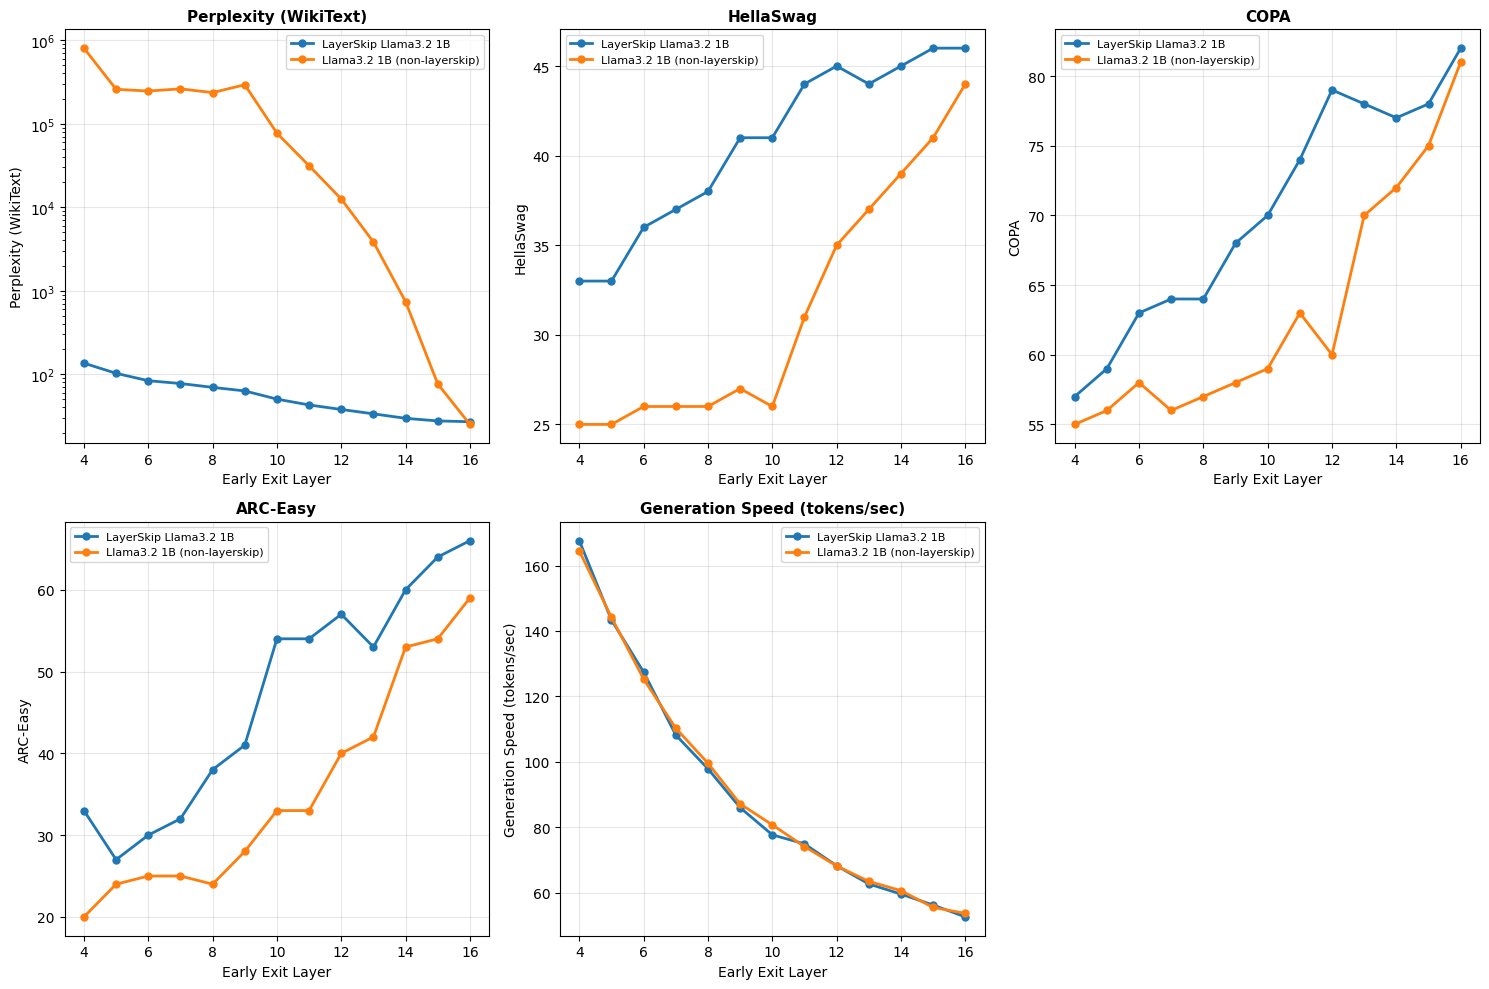


EVALUATION COMPLETE

Summary Statistics:

LayerSkip Llama3.2 1B:
  Best perplexity: 27.00 at layer 16
  HellaSwag: 46.00% at layer 15
  COPA: 82.00% at layer 16
  ARC-Easy: 66.00% at layer 16
  Speed: 167.63 tokens/sec at layer 4

Llama3.2 1B (non-layerskip):
  Best perplexity: 25.06 at layer 16
  HellaSwag: 44.00% at layer 16
  COPA: 81.00% at layer 16
  ARC-Easy: 59.00% at layer 16
  Speed: 164.48 tokens/sec at layer 4


In [7]:

import torch
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer
import time
import pandas as pd

def evaluate_perplexity(model, tokenizer, device, dataset_name="wikitext", split="test", max_samples=100):
    """Calculate perplexity on a dataset"""
    print(f"  Evaluating perplexity on {dataset_name}...")

    if dataset_name == "wikitext":
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split=split)
    else:
        dataset = load_dataset(dataset_name, split=split)

    dataset = dataset.select(range(min(max_samples, len(dataset))))

    total_loss = 0
    total_tokens = 0

    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="  Computing perplexity", leave=False):
            text = item['text'] if 'text' in item else str(item)

            if len(text.strip()) == 0:
                continue

            encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            input_ids = encodings.input_ids.to(device)

            if input_ids.shape[1] < 2:
                continue

            outputs = model(input_ids, labels=input_ids)
            num_tokens = input_ids.shape[1]
            total_loss += outputs.loss.item() * num_tokens
            total_tokens += num_tokens

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = np.exp(avg_loss)
    return perplexity


def evaluate_hellaswag(model, tokenizer, device, max_samples=100):
    """Evaluate on HellaSwag benchmark using multiple choice accuracy"""
    print(f"  Evaluating on HellaSwag...")

    dataset = load_dataset("Rowan/hellaswag", split="validation")
    dataset = dataset.select(range(min(max_samples, len(dataset))))

    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="  Computing HellaSwag accuracy", leave=False):
            ctx = item['ctx']
            endings = item['endings']
            label = int(item['label'])

            # Compute log probability for each ending
            log_probs = []
            for ending in endings:
                full_text = ctx + " " + ending

                # Tokenize
                inputs = tokenizer(full_text, return_tensors="pt").to(device)
                ctx_inputs = tokenizer(ctx, return_tensors="pt").to(device)

                # Get logits
                outputs = model(**inputs)
                logits = outputs.logits

                # Calculate log probability of the ending tokens
                ctx_len = ctx_inputs.input_ids.shape[1]
                ending_logits = logits[0, ctx_len-1:-1, :]
                ending_ids = inputs.input_ids[0, ctx_len:]

                # Get log probs
                log_probs_ending = torch.log_softmax(ending_logits, dim=-1)
                selected_log_probs = log_probs_ending[range(len(ending_ids)), ending_ids]
                total_log_prob = selected_log_probs.sum().item()

                log_probs.append(total_log_prob)

            # Predict the ending with highest log probability
            predicted = np.argmax(log_probs)
            if predicted == label:
                correct += 1
            total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    return accuracy


def evaluate_copa(model, tokenizer, device, max_samples=100):
    """Evaluate on COPA (Choice of Plausible Alternatives) benchmark"""
    print(f"  Evaluating on COPA...")

    dataset = load_dataset("super_glue", "copa", split="validation")
    dataset = dataset.select(range(min(max_samples, len(dataset))))

    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="  Computing COPA accuracy", leave=False):
            premise = item['premise']
            choice1 = item['choice1']
            choice2 = item['choice2']
            question = item['question']  # "cause" or "effect"
            label = int(item['label'])  # 0 or 1

            # Format based on question type
            if question == "cause":
                connector = " because"
            else:  # effect
                connector = " so"

            choices = [choice1, choice2]

            # Compute log probability for each choice
            log_probs = []
            for choice in choices:
                full_text = premise + connector + " " + choice

                # Tokenize
                inputs = tokenizer(full_text, return_tensors="pt").to(device)
                premise_inputs = tokenizer(premise + connector, return_tensors="pt").to(device)

                # Get logits
                outputs = model(**inputs)
                logits = outputs.logits

                # Calculate log probability of the choice tokens
                premise_len = premise_inputs.input_ids.shape[1]
                choice_logits = logits[0, premise_len-1:-1, :]
                choice_ids = inputs.input_ids[0, premise_len:]

                # Get log probs
                log_probs_choice = torch.log_softmax(choice_logits, dim=-1)
                selected_log_probs = log_probs_choice[range(len(choice_ids)), choice_ids]
                total_log_prob = selected_log_probs.sum().item()

                log_probs.append(total_log_prob)

            # Predict the choice with highest log probability
            predicted = np.argmax(log_probs)
            if predicted == label:
                correct += 1
            total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    return accuracy


def evaluate_arc_easy(model, tokenizer, device, max_samples=100):
    """Evaluate on ARC-Easy benchmark"""
    print(f"  Evaluating on ARC-Easy...")

    dataset = load_dataset("allenai/ai2_arc", "ARC-Easy", split="test")
    dataset = dataset.select(range(min(max_samples, len(dataset))))

    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="  Computing ARC-Easy accuracy", leave=False):
            question = item['question']
            choices_dict = item['choices']
            choices = choices_dict['text']
            labels = choices_dict['label']
            answer_key = item['answerKey']

            # Find the index of the correct answer
            try:
                answer_idx = labels.index(answer_key)
            except:
                continue

            # Format question
            prompt = f"Question: {question}\n"

            # Compute log probability for each choice
            log_probs = []
            for i, choice in enumerate(choices):
                full_text = f"{prompt}Answer: {choice}"

                # Tokenize
                inputs = tokenizer(full_text, return_tensors="pt").to(device)
                prompt_inputs = tokenizer(f"{prompt}Answer:", return_tensors="pt").to(device)

                # Get logits
                outputs = model(**inputs)
                logits = outputs.logits

                # Calculate log probability of the answer tokens
                prompt_len = prompt_inputs.input_ids.shape[1]
                answer_logits = logits[0, prompt_len-1:-1, :]
                answer_ids = inputs.input_ids[0, prompt_len:]

                # Get log probs
                log_probs_answer = torch.log_softmax(answer_logits, dim=-1)
                selected_log_probs = log_probs_answer[range(len(answer_ids)), answer_ids]
                total_log_prob = selected_log_probs.sum().item()

                log_probs.append(total_log_prob)

            predicted = np.argmax(log_probs)
            if predicted == answer_idx:
                correct += 1
            total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    return accuracy


def evaluate_generation_speed(model, tokenizer, device, prompt, max_new_tokens=512):
    """Measure generation speed"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    batch_time = time.time() - start_time

    # Calculate tokens per second
    num_tokens_generated = outputs.shape[1] - inputs.input_ids.shape[1]
    tokens_per_sec = num_tokens_generated / batch_time if batch_time > 0 else 0

    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    return {
        'batch_time': batch_time,
        'tokens_generated': num_tokens_generated,
        'tokens_per_sec': tokens_per_sec,
        'generated_text': generated_text
    }


def evaluate_model_at_different_exits(checkpoint, model_name, device, prompt, max_samples=100):
    """Evaluate a single model at different early exit points"""

    print(f"\n{'='*80}")
    print(f"Loading model: {checkpoint}")
    print(f"{'='*80}")

    base_model = AutoModelForCausalLM.from_pretrained(
        checkpoint,
        device_map="auto",
        use_safetensors=True,
        torch_dtype=torch.bfloat16
    )
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # Set pad token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Get total number of layers
    num_layers = len(base_model.model.layers)
    print(f"Total layers in model: {num_layers}")

    # Define early exit points to test
    early_exit_points = list(range(4, num_layers + 1))

    print(f"Testing early exit points: {early_exit_points}")

    # Store results
    results = []

    for early_exit in early_exit_points:
        print(f"\n{'-'*80}")
        print(f"Evaluating Early Exit at Layer {early_exit}/{num_layers}")
        print(f"{'-'*80}")

        # Create model with early exit
        weights_memo = {id(w): w for w in base_model.parameters()}
        eval_model = deepcopy(base_model, memo=weights_memo)

        if early_exit < num_layers:
            eval_model.model.layers = eval_model.model.layers[:early_exit]
            del eval_model.model.layers[early_exit:]
            print(f"  Truncated to {len(eval_model.model.layers)} layers")
        else:
            print(f"  Using full model ({num_layers} layers)")

        # Evaluate perplexity on WikiText
        ppl_wikitext = evaluate_perplexity(
            eval_model,
            tokenizer,
            device,
            dataset_name="wikitext",
            max_samples=max_samples
        )

        # Evaluate benchmarks
        hellaswag_acc = evaluate_hellaswag(eval_model, tokenizer, device, max_samples)
        copa_acc = evaluate_copa(eval_model, tokenizer, device, max_samples)
        arc_easy_acc = evaluate_arc_easy(eval_model, tokenizer, device, max_samples)

        # Evaluate generation speed
        gen_results = evaluate_generation_speed(
            eval_model,
            tokenizer,
            device,
            prompt,
            max_new_tokens=512
        )

        # Store results
        result = {
            'model': model_name,
            'early_exit_layer': early_exit,
            'perplexity_wikitext': ppl_wikitext,
            'hellaswag_accuracy': hellaswag_acc,
            'copa_accuracy': copa_acc,
            'arc_easy_accuracy': arc_easy_acc,
            'generation_time_sec': gen_results['batch_time'],
            'tokens_generated': gen_results['tokens_generated'],
            'tokens_per_sec': gen_results['tokens_per_sec'],
        }
        results.append(result)

        print(f"  ✓ Perplexity (WikiText): {ppl_wikitext:.2f}")
        print(f"  ✓ HellaSwag: {hellaswag_acc:.2f}%")
        print(f"  ✓ COPA: {copa_acc:.2f}%")
        print(f"  ✓ ARC-Easy: {arc_easy_acc:.2f}%")
        print(f"  ✓ Generation time: {gen_results['batch_time']:.2f}s")
        print(f"  ✓ Tokens/sec: {gen_results['tokens_per_sec']:.2f}")

        # Clean up
        del eval_model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Clean up base model
    del base_model
    del tokenizer
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results


# Main evaluation code
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "from typing import List\ndef bucket_sort(A: List):"

# Models to evaluate
models_to_evaluate = [
    {
        'checkpoint': "facebook/layerskip-llama3.2-1B",
        'name': "LayerSkip Llama3.2 1B"
    },
    {
        'checkpoint': "meta-llama/Llama-3.2-1B",
        'name': "Llama3.2 1B (non-layerskip)"
    },
]

# Collect all results
all_results = []

for model_config in models_to_evaluate:
    results = evaluate_model_at_different_exits(
        checkpoint=model_config['checkpoint'],
        model_name=model_config['name'],
        device=device,
        prompt=prompt,
        max_samples=100  # Increase for more accurate results
    )
    all_results.extend(results)

# Create DataFrame with all results
df_results = pd.DataFrame(all_results)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(df_results.to_string(index=False))

# Save to CSV
df_results.to_csv('layerskip_comparison_results.csv', index=False)
print("\nResults saved to 'layerskip_comparison_results.csv'")

# Plot results
try:
    import matplotlib.pyplot as plt

    # Create figure with 2x3 grid (4 benchmarks + speed)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    benchmarks = [
        ('perplexity_wikitext', 'Perplexity (WikiText)', True),
        ('hellaswag_accuracy', 'HellaSwag', False),
        ('copa_accuracy', 'COPA', False),
        ('arc_easy_accuracy', 'ARC-Easy', False),
        ('tokens_per_sec', 'Generation Speed (tokens/sec)', False)
    ]

    for idx, (metric, title, log_scale) in enumerate(benchmarks):
        ax = axes[idx]

        for model_name in df_results['model'].unique():
            model_data = df_results[df_results['model'] == model_name]
            ax.plot(
                model_data['early_exit_layer'],
                model_data[metric],
                'o-',
                linewidth=2,
                markersize=5,
                label=model_name
            )

        ax.set_xlabel('Early Exit Layer', fontsize=10)
        ax.set_ylabel(title, fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

        if log_scale:
            ax.set_yscale('log')

    # Hide extra subplot
    axes[-1].axis('off')

    plt.tight_layout()
    plt.savefig('layerskip_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
    print("Plot saved as 'layerskip_comprehensive_comparison.png'")
    plt.show()

except ImportError:
    print("\nMatplotlib not available - skipping plots")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)

# Print summary statistics
print("\nSummary Statistics:")
for model_name in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model_name]
    print(f"\n{model_name}:")
    print(f"  Best perplexity: {model_data['perplexity_wikitext'].min():.2f} at layer {model_data.loc[model_data['perplexity_wikitext'].idxmin(), 'early_exit_layer']:.0f}")
    print(f"  HellaSwag: {model_data['hellaswag_accuracy'].max():.2f}% at layer {model_data.loc[model_data['hellaswag_accuracy'].idxmax(), 'early_exit_layer']:.0f}")
    print(f"  COPA: {model_data['copa_accuracy'].max():.2f}% at layer {model_data.loc[model_data['copa_accuracy'].idxmax(), 'early_exit_layer']:.0f}")
    print(f"  ARC-Easy: {model_data['arc_easy_accuracy'].max():.2f}% at layer {model_data.loc[model_data['arc_easy_accuracy'].idxmax(), 'early_exit_layer']:.0f}")
    print(f"  Speed: {model_data['tokens_per_sec'].max():.2f} tokens/sec at layer {model_data.loc[model_data['tokens_per_sec'].idxmax(), 'early_exit_layer']:.0f}")

Plot saved as 'selected_benchmarks.png'


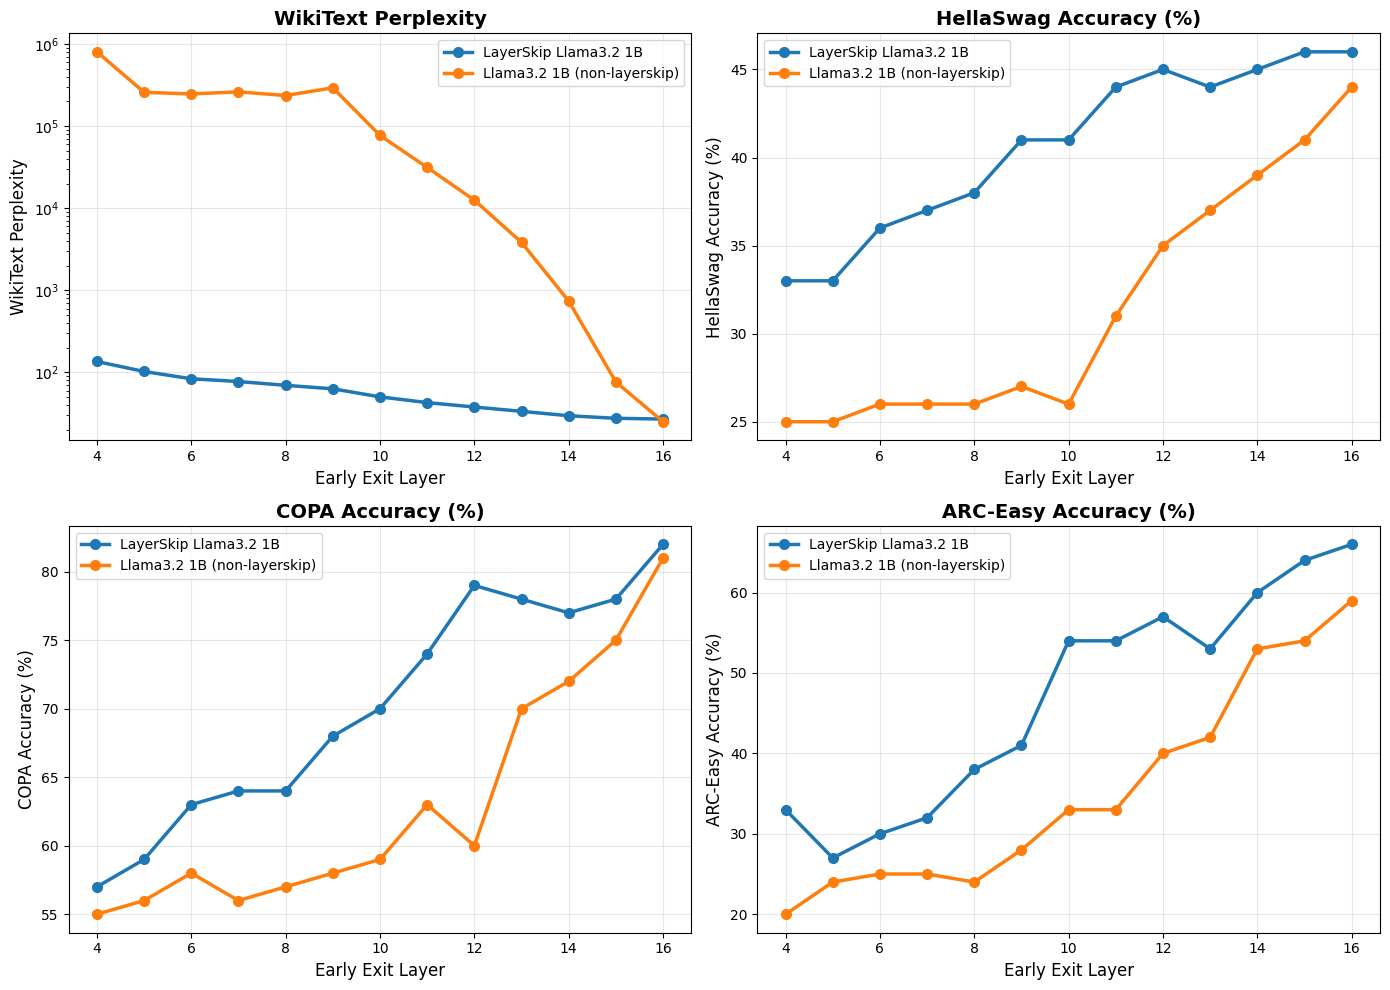


SUMMARY FOR SELECTED BENCHMARKS

LayerSkip Llama3.2 1B:
  WikiText Perplexity: 27.00 (best at layer 16)
  HellaSwag: 46.00% (best at layer 15)
  COPA: 82.00% (best at layer 16)
  ARC-Easy: 66.00% (best at layer 16)

Llama3.2 1B (non-layerskip):
  WikiText Perplexity: 25.06 (best at layer 16)
  HellaSwag: 44.00% (best at layer 16)
  COPA: 81.00% (best at layer 16)
  ARC-Easy: 59.00% (best at layer 16)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results
df_results = pd.read_csv('layerskip_comparison_results.csv')

# Create figure with 2x2 grid for the 4 benchmarks
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Define the 4 benchmarks to plot
benchmarks = [
    ('perplexity_wikitext', 'WikiText Perplexity', True),  # log scale
    ('hellaswag_accuracy', 'HellaSwag Accuracy (%)', False),
    ('copa_accuracy', 'COPA Accuracy (%)', False),
    ('arc_easy_accuracy', 'ARC-Easy Accuracy (%)', False),
]

# Plot each benchmark
for idx, (metric, title, log_scale) in enumerate(benchmarks):
    ax = axes[idx]

    for model_name in df_results['model'].unique():
        model_data = df_results[df_results['model'] == model_name]
        ax.plot(
            model_data['early_exit_layer'],
            model_data[metric],
            'o-',
            linewidth=2.5,
            markersize=7,
            label=model_name
        )

    ax.set_xlabel('Early Exit Layer', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)

    if log_scale:
        ax.set_yscale('log')

plt.tight_layout()
plt.savefig('selected_benchmarks.png', dpi=150, bbox_inches='tight')
print("Plot saved as 'selected_benchmarks.png'")
plt.show()

# Print summary for these benchmarks
print("\n" + "="*80)
print("SUMMARY FOR SELECTED BENCHMARKS")
print("="*80)

for model_name in df_results['model'].unique():
    model_data = df_results[df_results['model'] == model_name]
    print(f"\n{model_name}:")
    print(f"  WikiText Perplexity: {model_data['perplexity_wikitext'].min():.2f} (best at layer {model_data.loc[model_data['perplexity_wikitext'].idxmin(), 'early_exit_layer']:.0f})")
    print(f"  HellaSwag: {model_data['hellaswag_accuracy'].max():.2f}% (best at layer {model_data.loc[model_data['hellaswag_accuracy'].idxmax(), 'early_exit_layer']:.0f})")
    print(f"  COPA: {model_data['copa_accuracy'].max():.2f}% (best at layer {model_data.loc[model_data['copa_accuracy'].idxmax(), 'early_exit_layer']:.0f})")
    print(f"  ARC-Easy: {model_data['arc_easy_accuracy'].max():.2f}% (best at layer {model_data.loc[model_data['arc_easy_accuracy'].idxmax(), 'early_exit_layer']:.0f})")